In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import collections
tf.disable_v2_behavior()
print(tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
2.3.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
os.chdir("/content/gdrive/MyDrive/BKDN/Đồ Án/Fashion_MLP")

In [4]:
# Đọc dữ liệu users
def _read_users():
  users = pd.read_csv('data/users.csv', 
                      dtype={'user_id':str})
  return users

# Đọc dữ liệu ratings
def _read_ratings():
  ratings = pd.read_csv('data/rate_history.csv',
                        dtype={'user_id':str,
                               'product_id':str})
  return ratings

# Đọc dữ liệu về các sản phẩm
def _read_products():
  products = pd.read_csv('data/products.csv', 
                       dtype={'product_id':str,
                              'price':str})
  products = products[['product_id','name','price','category']]
  return products

users = _read_users()
ratings = _read_ratings()
products = _read_products()

In [5]:
def myFunc(x):
  new = x.replace(u'\xa0₫', u'').replace('.','')
  return new

products['price'] = products['price'].apply(myFunc)

In [10]:
categories = pd.read_csv('data/categories.csv')
categories

,id,name
0,0,Áo Khoác Nam
1,1,Áo Sơ Mi Nam
2,2,Áo Thun Nam
3,3,Quần Tây Nam
4,4,Quần Short - Quần Lửng Nam
...,...,...
63,63,Thắt lưng - Dây nịt Nữ
64,64,Mũ - Nón Nữ
65,65,Mắt Kính Nữ
66,66,Khăn Nữ


In [11]:
users

,user_id,sex
0,0,M
1,1,M
2,2,M
3,3,M
4,4,M
...,...,...
385,385,F
386,386,F
387,387,F
388,388,F


In [ ]:
ratings 

,user_id,product_id
0,0,71
1,0,62
2,0,15
3,0,70
4,0,4
...,...,...
10181,389,5078
10182,389,5080
10183,389,5085
10184,389,5070


In [12]:
products

,product_id,name,price,category
0,0,Áo cardigan nam phong cách hàn quốc - Xanh đen,299000,Áo Khoác Nam
1,1,Áo khoác Kaki Pilot Landing trẻ trung - Đen,165000,Áo Khoác Nam
2,2,Áo khoác kaki nam nữ đại bàng cá tính - Trắng,245000,Áo Khoác Nam
3,3,Áo khoác unisex phối chữ cá tính - Xanh đen,179000,Áo Khoác Nam
4,4,Áo khoác dù nam nữ cá tính - Xanh lá,235000,Áo Khoác Nam
...,...,...,...,...
5088,5088,Quần tất nữ siêu co giãn phong cách - Đen,149000,Tất - Vớ Nữ
5089,5089,Quần vớ đạp gót nữ thời trang - Xám,115000,Tất - Vớ Nữ
5090,5090,Combo 3 quần tất thời trang,99000,Tất - Vớ Nữ
5091,5091,Combo 5 đôi vớ nữ cổ ngắn Starts,127000,Tất - Vớ Nữ


In [13]:
# Hàm chia data thành tập train/test
def split_train_test(df, split_rate=0.2):
  """Chia dữ liệu dataframe thành tập train và test.
  Args:
    df: dataframe.t
    holdout_fraction: tỷ lệ số dòng của dataframe được sử dụng trong tập test.
  Returns:
    train: dataframe cho huấn luyện
    test: dataframe cho kiểm định
  """
  test = df.sample(frac=split_rate, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [14]:
user_rates = ratings.groupby('user_id').product_id.apply(list).reset_index()
user_rates

,user_id,product_id
0,0,"[73, 92, 27, 90, 16, 19, 34, 39, 1, 15, 21, 30..."
1,1,"[30, 39, 12, 26, 24, 82, 1, 36, 73, 58, 90, 19..."
2,10,"[271, 273, 263, 257, 278, 281, 274, 284, 285, ..."
3,100,"[1283, 1275, 1299, 1305, 1311, 1330, 1334, 133..."
4,101,"[1337, 1310, 1330, 1343, 1333, 1300, 1283, 133..."
...,...,...
385,95,"[1240, 1185, 1188, 1224, 1258, 1171, 1174, 121..."
386,96,"[1271, 1341, 1353, 1325, 1331, 1346, 1349, 127..."
387,97,"[1349, 1280, 1273, 1325, 1346, 1303, 1291, 134..."
388,98,"[1270, 1297, 1304, 1342, 1323, 1351, 1267, 135..."


In [15]:
categories_dict = {
    product: category for product, category  in zip(products["product_id"], products["category"])
}
prices_dict = {
    product: price for product, price  in zip(products["product_id"], products["price"])
}
user_dict = {
    user: sex
    for user, sex in zip(users["user_id"], users["sex"])
}
def data_gen_batch(user_rates, batch_size):
  """Khởi tạo ra một batch input chính là các product embedding
  Argument:
    user_rates: DataFrame lịch sử các sản phẩm đã rate của user sao cho cột "product_id" là danh sách các sản phẩm đã được xem bởi user.
    batch_size: Kích thước mẫu.
  """
  # Hàm pad để đưa các véc tơ category không có cùng kích thước của 1 biến về chung 1 kích thước.
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values
  
  # list danh sách các product_id mà user đã rate
  product = []
  # category là thể loại phim
  category = []
  #price la gia tien
  price = []
  # label là product_id của sản phẩm
  label = []
  # Các thông tin user:
  sex = []
  for i, (product_ids, user_id) in user_rates[["product_id", "user_id"]].iterrows():
    # Khởi tạo các thông tin liên quan đến product
    n_products = len(product_ids)
    product.append(product_ids)
    price.append([prices_dict[product_id] for product_id in product_ids])
    category.append([categories_dict[product_id] for product_id in product_ids])
    label.append([int(product_id) for product_id in product_ids])
    # Khởi tạo các thông tin liên quan đến user
    sex.append([user_dict[user_id]]*n_products)
  # Khởi tạo batch từ feature huấn luyện
  features = {
      'product_id': pad(product, ""),
      'category': pad(category, ""),
      'price': pad(price, ""),
      'sex': pad(sex, ""),
      'label': pad(label, -1)
  }
  batch = (
  tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      # Khai báo kích thước batch
      .batch(batch_size)
      # Khởi tạo vòng lặp iterator qua từng batch
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Lựa chọn một số phần tử ngẫu nhiên từ mỗi một dòng của x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  # Trả về khoảng range từ 0 --> batch_size
  rn = tf.range(batch_size)
  # Đếm số lượng giá trị >= 0 của dòng x
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  # Trả về một chuỗi random có kích thước là batch_size và giá trị mỗi phần tử trong khoảng (0, 1)
  rnd = tf.random_uniform([batch_size])
  # Stack row indexes and column indexes
  # Khởi tạo list các ids gồm (index_row, index_col). 
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  # Trích suất các index ngẫu nhiên từ x theo ids. Mỗi dòng sẽ lấy 1 phần tử là index của product mà khách hàng đã rate.
  return to_int(tf.gather_nd(x, ids))

In [16]:
def loss_cross_entropy(user_embeddings, product_embeddings, labels):
  """Trả về hàm cross-entropy loss function.
  Args:
    user_embeddings: một tensor shape [batch_size, embedding_dim].
    product_embeddings: một tensor shape [num_products, embedding_dim].
    labels: một sparse tensor có kích thước [batch_size, 1], tensor này chỉ lưu index của vị trí khác 0. 
    Chẳng hạn labels[i] là product_id của sản phẩm được xem của mẫu i.
  Returns:
    mean cross-entropy loss.
  """
  # Số chiều của user_embeddings phải bằng với product_embeddings
  # assert user_embeddings.shape[1].value == product_embeddings.shape[1].value
  # Tính giá trị logits
  logits = tf.matmul(user_embeddings, product_embeddings, transpose_b=True)
  # Hàm loss function
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [17]:
# Khởi tạo class RecNeuralNet hỗ trợ huấn luyện mô hình
class RecNeuralNet(object):
  """Một class biểu diễn mô hình collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Khởi tạo RecNeuralNet.
    Args:
      embedding_vars: Từ điển của các biến đầu vào. Định dạng tf.Variable().
      loss: Hàm loss function cần được tối ưu hóa. Định dạng float Tensor.
      metrics: Một list các dictionaries của các tensors. Các metrics trong mỗi dictionary sẽ được visualize trên các biểu đồ khác nhau 
      trong suốt quá trình huấn luyện.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    # Khởi tạo none embeddings dictionary
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """trả về embeddings."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.keras.optimizers.SGD):
    """Huấn luyện model.
    Args:
      iterations: số lượng iterations huấn luyện.
      learning_rate: learning rate optimizer.
      plot_results: có vẽ biểu đồ sau khi huấn luyện xong mô hình hay không?
      optimizer: object optimizer được sử dụng để huấn luyện mô hình. Mặc định là GradientDescentOptimizer.
    Returns:
      Dictionary là các metrics được đánh giá tại vòng lặp cuối cùng.
    """
    # Khởi tạo các train_operation là quá trình tối thiểu hóa hàm loss function.
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()
          
    # Huấn luyện mô hình trong session
    with self._session.as_default():
      # Kích hoạt khởi tạo các biến local
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Huấn luyện mô hình và append results
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        # In ra kết quả các metrics sau mỗi 10 vòng lặp.
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)

          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      # Lưu các giá trị user_embedding, product_embedding vào embedding dictionary
      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()
      # Vẽ biểu đồ các metrics được đo lường.
      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [18]:
def init_softmax_model(rated_products, embedding_cols, hidden_dims):
  """Xây dựng mô hình Softmax cho productLens.
  Args:
    rated_products: DataFrame chứa list các sản phẩm mà user đã rate.
    embedding_cols: là list các dictionary sao cho mỗi một dictionary mapping các feature names vào các véc tơ embedding của input dataframe. 
    list các dictionaries này sẽ được sử dụng trong tf.feature_column.input_layer() để khởi tạo input layer nhằm 
    mapping sparse input features --> input embeddings như hình vẽ kiến trúc mô hình.
    hidden_dims: list các kích thước của lần lượt các hidden layers.
  Returns:
    một RecNeuralNet object.
  """
  def user_embedding_network(features):
    """Maps input features dictionary với user embeddings.
    Args:
      features: một dictionary của input dạng string tensors.
    Returns:
      outputs: một tensor shape [batch_size, embedding_dim].
    """
    # Khởi tạo một bag-of-words embedding cho mỗi sparse features thông qua embedding_cols
    # Ở đây ta sử dụng một thủ thuật nhúng các biến category thành các one-hot và sau đó concatenate chúng ở đầu vào thông qua hàm tf.feature_column.input_layer(features, embedding_cols)
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_products, test_rated_products = split_train_test(rated_products)
  # Khởi tạo các product embedding trên train/test
  train_batch = data_gen_batch(train_rated_products, 128)
  test_batch = data_gen_batch(test_rated_products, 64)

  # Khởi tạo variable_scope để tái sử dụng lại các biến của nó
  with tf.variable_scope("model", reuse=False):
    # Tạo véc tơ nhúng user embedding
    train_user_embeddings = user_embedding_network(train_batch)
    # Lấy ngẫu nhiên label từ batch size
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Tạo véc tơ nhúng user embedding
    test_user_embeddings = user_embedding_network(test_batch)
    # Lấy ngẫu nhiên label từ test batch
    test_labels = select_random(test_batch["label"])
    # Trích xuất các product_embeddings là layer cuối cùng của mạng neural
    # Lấy variable product_embeddings có tên như bên dưới hoặc tạo product_embeddings variable nếu nó chưa tồn tại
    product_embeddings = tf.get_variable(
        "input_layer/product_id_embedding/embedding_weights")
  
  # Xây dựng các hàm loss function trên train và test từ các đầu vào đã biết là user_embeddings, product_embeddings (chính là các batch) và labels
  train_loss = loss_cross_entropy(train_user_embeddings, product_embeddings, train_labels)
  test_loss = loss_cross_entropy(test_user_embeddings, product_embeddings, test_labels)
  # Kiểm tra độ chính xác trên tập test chỉ tại k class có xác suất dự báo lớn nhất. 
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels = test_labels,
      predictions = tf.matmul(test_user_embeddings, product_embeddings, transpose_b=True),
      k=10
  )

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"product_id": product_embeddings,
                "user_id": train_user_embeddings}
  return RecNeuralNet(embeddings, train_loss, metrics)

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprec

({'test_loss': 5.3860645, 'train_loss': 3.3526936},
 {'test_precision_at_10': 0.03549080367852859})

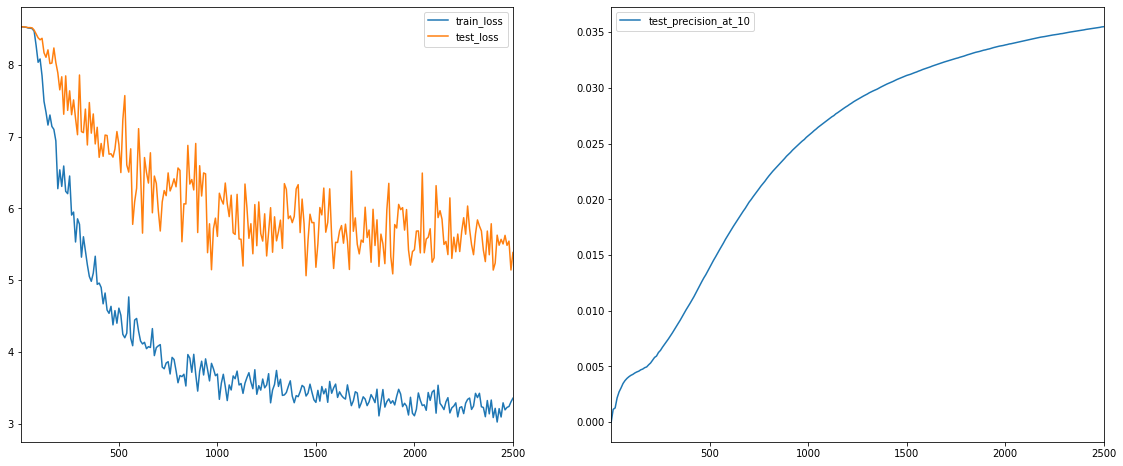

In [19]:
# Khởi tạo hàm số giúp embedding các category sang véc tơ embedding.
def _embedding_category_col(key, embedding_dim, table_name = 'products'):
  """
  key: tên cột dạng category cần khởi tạo vocabulary, tên cột phải trùng với tên các key trong features dict của batch
  embedding_dim: số chiều dữ liệu được sử dụng để nhúng các categorical_column
  """
  if table_name == 'products':
    categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
          key=key, vocabulary_list=list(set(products[key].values)), num_oov_buckets=0)
  elif table_name == 'users':
    categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=key, vocabulary_list=list(set(users[key].values)), num_oov_buckets=0)
  # Trả về embedding véc tơ từ dictionary.
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = init_softmax_model(
      user_rates,
      embedding_cols=[
          _embedding_category_col("product_id", 35),
          _embedding_category_col("category", 5),
          _embedding_category_col("price", 8),
          _embedding_category_col("sex", 2, "users"),
      ],
      hidden_dims=[35])

softmax_model.train(learning_rate=4., num_iterations=2500, optimizer=tf.train.AdagradOptimizer)

In [20]:
DOT = 'dot'
COSINE = 'cosine'
def _compute_similarity(query_embedding, item_embeddings, measure=DOT):
  """Tính điểm số giữa câu query và item embedding.
  Args:
    query_embedding: là một vector nhúng của query kích thước [k].
    item_embeddings: là ma trận nhúng véc tơ các items kích thước [N, k].
    measure: là một chuỗi string xác định kiểu đo lường tương đương được sử dụng. Có thể là theo phương pháp 'dot similarity' hoặc 'cosine similarity'.
  Returns:
    scores: một véc tơ kích thước [N], sao cho score[i] là điểm của item i được cho bởi query.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [21]:
def _product_similarity(model, product_id, measure=DOT, k=10):
  # Lọc ra title của sản phẩm
  titles = products[products['product_id']==str(product_id)]['name'].values
  print('product title: {}'.format(titles))
  if len(titles) == 0:
    raise ValueError("Found no products with product_id %s" % product_id)
  print("Nearest neighbors of : %s." % titles[0])
  scores = _compute_similarity(
      model.embeddings["product_id"][product_id], model.embeddings["product_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'product_id': products['product_id'],
      'names': products['name'],
      'categories': products['category']
  })
  return df.sort_values([score_key], ascending=False).head(k)

In [22]:
result = _product_similarity(softmax_model, product_id=311, measure=COSINE, k=20)
result

product title: ['Quần tây nam Mốt Trẻ BQP104 - Đen']
Nearest neighbors of : Quần tây nam Mốt Trẻ BQP104 - Đen.


,cosine score,product_id,names,categories
311,1.000000,311,Quần tây nam Mốt Trẻ BQP104 - Đen,Quần Tây Nam
293,0.981632,293,"Quần kaki Nam Kumas nam tính 16004-01,2,4 - Xa...",Quần Tây Nam
290,0.979444,290,"Quần kaki Nam Kumas nam tính 16004-01,2,4 - Đen",Quần Tây Nam
296,0.975329,296,Quần tây nam công sở Vũ Tuấn SL001-1 - Đen,Quần Tây Nam
306,0.974952,306,Quần Âu Nam Ống Côn Sắc Đen Sang Trọng - Đen,Quần Tây Nam
341,0.969062,341,Quần tây nam Mốt Trẻ BQP103 - Xám,Quần Tây Nam
329,0.967486,329,Quần tây nam công sở Vũ Tuấn SL003-1 - Xám,Quần Tây Nam
335,0.964750,335,Quần tây nam công sở Vũ Tuấn CTM001-4 - Nâu,Quần Tây Nam
337,0.964579,337,Quần Tây Nam Mốt Trẻ Thanh Lịch - Đen,Quần Tây Nam
339,0.963098,339,Quần Tây Nam BQ Mốt Trẻ - Xám,Quần Tây Nam


In [23]:
products.to_pickle('data/products.pkl')

In [24]:
import pickle
f = open("data/embeddings.pkl", "wb")
pickle.dump(softmax_model.embeddings, file=f)
f.close()

In [ ]:
# f = open("data/embeddings.pkl", "rb")
# data = pickle.load(f)
# f.close()

In [ ]:
# products_exx = pd.read_pickle('data/products.pkl')
# products_exx